# Datathon 2025

Problem Statement
- Build analytics tool to extract entities and relationships from unstructured text given in the dataset
- Perform necessary data validation and quality checks when building analytics tool
- Demonstrate how the tool can extract meaningful insights from the source texts provided
- Incorporate relevant visual aids in the demonstrating the viability of tool and insights gleaned from applying tool to source texts provided (e.g. network graphs demonstrating complex relationships)

### Load in the dataset

In [1]:
import pandas as pd
import numpy as np
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline, AutoModelForSequenceClassification
import torch

/Users/yunjia/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Load the dataset
df = pd.read_csv('news_excerpts.csv')

df = df['Text']

In [3]:
df.head()

0    Starbucks violated federal labor law when it i...
1    The first suspect to plead guilty in Singapore...
2    Meta has been fined a record-breaking €1.2 bil...
3    SINGAPORE: A 45-year-old man linked to Singapo...
4    The Department of Education imposed a record $...
Name: Text, dtype: object

### Data Cleaning and Preparation

#### #1: Normalize Whitespace
Convert multiple spaces to a single space and remove leading/trailing spaces.

In [4]:
df = df.apply(lambda x: ' '.join(x.split()))

#2: Tackle the Missing Values

In [5]:
texts = df.dropna().tolist()

In [6]:
print(texts[:2])

['Starbucks violated federal labor law when it increased wages and offered new perks and benefits only to non-union employees, a National Labor Relations Board judge found Thursday. The decision is the latest in a series of NLRB rulings finding that Starbucks has violated labor law in its efforts to stop unions from forming in its coffee shops. “The issue at the heart of this case is whether, under current Board law, [Starbucks] was entitled to explicitly reward employees,” for not participating in union activity, “while falsely telling its workers that the federal labor law forced it to take this action,” wrote administrative law judge Mara-Louise Anzalone. “It was not.”', "The first suspect to plead guilty in Singapore's largest money laundering case was convicted and sentenced to 13 months' jail in a district court on Tuesday (Apr 2). Su Wenqiang, 32, admitted to 11 charges of money laundering, possessing proceeds from illegal remote gambling offences and lying to get work passes fo

## Named Entity Recognition using spaCy
Identifying entities such as people, organizations, dates, and locations in a list of texts.

In [7]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Extract named entities
entities = []
for text in texts:
    doc = nlp(text)
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))

# Convert to DataFrame for analysis
entities_df = pd.DataFrame(entities, columns=["Entity", "Type"])
print(entities_df.head())

                           Entity  Type
0  National Labor Relations Board   ORG
1                        Thursday  DATE
2                            NLRB   ORG
3                       Starbucks   ORG
4                           Board   ORG


In [8]:
# Example Text to process
text = """The first suspect to plead guilty in Singapore's largest money laundering case was convicted and sentenced to 13 months' jail in a district court on Tuesday (Apr 2). Su Wenqiang, 32, admitted to 11 charges of money laundering, possessing proceeds from illegal remote gambling offences and lying to get work passes for himself and his wife."""

# Process the text
doc = nlp(text)

# Extract entities and their labels
for ent in doc.ents:
    print(ent.text, ent.label_)

first ORDINAL
Singapore GPE
13 months' DATE
Tuesday DATE
2 CARDINAL
Su Wenqiang PERSON
32 DATE
11 CARDINAL


### Extracting and Visualizing Entity Relationships using Dependency Parsing

         Entity1 Relation                           Entity2
0       violated    nsubj                         Starbucks
1       violated     dobj                 federal labor law
2      increased    nsubj                                it
3      increased     dobj                             wages
4        offered     dobj                         new perks
...          ...      ...                               ...
68838         by     pobj         the Bloomberg news agency
68839  regulated    nsubj                               MAS
68840  regulated     dobj  cryptocurrency service providers
68841  possessed    nsubj                              they
68842  possessed     dobj                             money

[68843 rows x 3 columns]


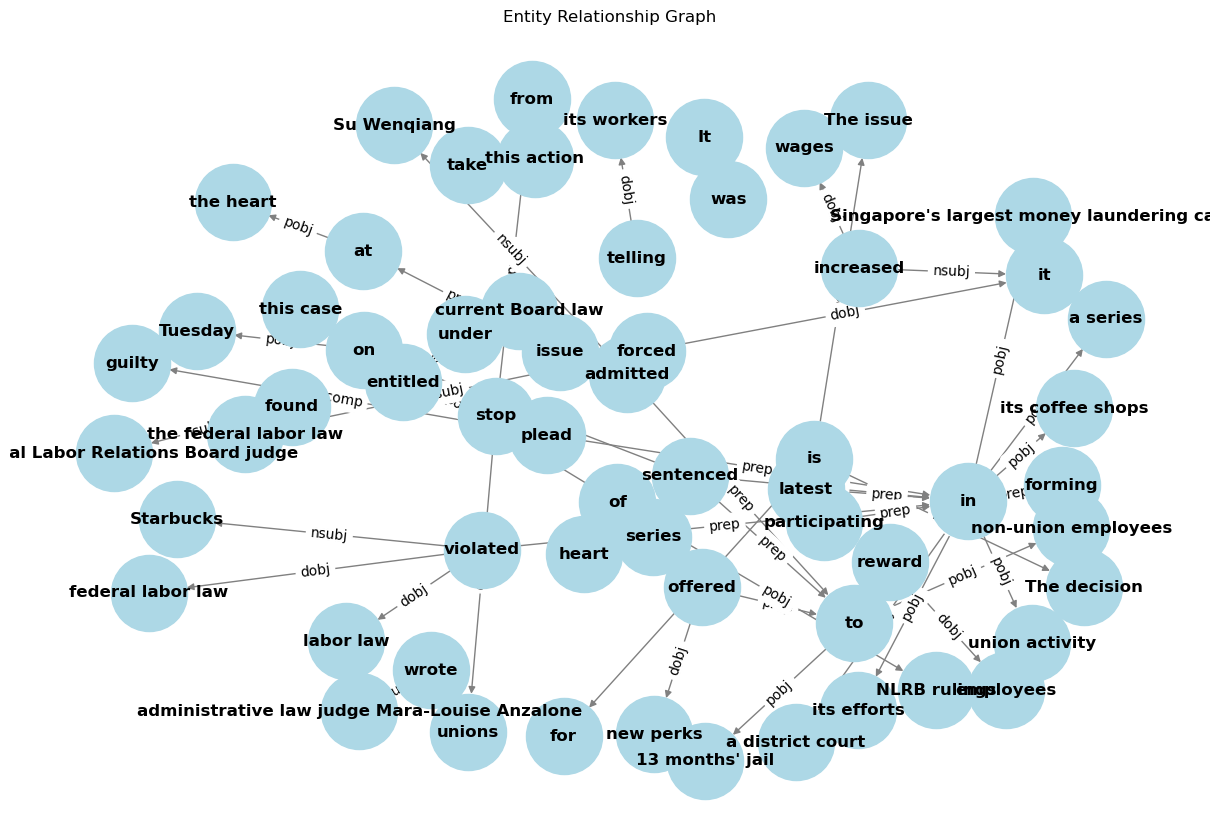

In [9]:
def get_noun_phrases(doc):
    noun_phrases = {chunk.root: chunk.text for chunk in doc.noun_chunks}  # Mapping root words to full phrases
    return noun_phrases

# Function to merge proper nouns joined by "and"
def merge_proper_nouns(doc):
    tokens = list(doc)
    merged_tokens = []
    i = 0

    while i < len(tokens):
        token = tokens[i]

        # If the token is a proper noun and followed by "and" + another proper noun
        if token.pos_ == "PROPN" and i + 2 < len(tokens) and tokens[i + 1].text.lower() == "and" and tokens[i + 2].pos_ == "PROPN":
            merged_entity = f"{token.text} and {tokens[i + 2].text}"
            merged_tokens.append(merged_entity)
            i += 3  # Skip the next two tokens ("and" and the second proper noun)
        else:
            merged_tokens.append(token.text)
            i += 1

    return merged_tokens

# List to store extracted relationships
relations = []

# Process each text
for text in texts:
    doc = nlp(text)

    # Get noun phrases (e.g., "federal law" instead of just "law")
    noun_phrases = get_noun_phrases(doc)

    # Merge proper nouns with "and"
    merged_tokens = merge_proper_nouns(doc)

    for token in doc:
        # Identify subject-object pairs (Who did what to whom?)
        if token.dep_ in ("nsubj", "dobj", "prep", "pobj", "attr", "acomp", "iobj"):  # Subject-Object dependency
            head = token.head.text  # The main verb (action word)
            entity = noun_phrases.get(token, token.text)  # Use full noun phrase if available

            # Replace entity if it appears in the merged list
            if entity in merged_tokens:
                entity = merged_tokens[merged_tokens.index(entity)]

            relation = token.dep_  # Relationship type (nsubj/dobj)
            relations.append((head, relation, entity))


relations_df = pd.DataFrame(relations, columns=["Entity1", "Relation", "Entity2"])

# Display results
print(relations_df)


# Create a directed graph
G = nx.DiGraph()

# Add edges for each relationship
for entity1, relation, entity2 in relations[:50]:  # Limit to first 50 for visualization
    G.add_edge(entity1, entity2, label=relation)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15, iterations=20)  # Adjust for a more readable layout
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=12, font_weight='bold')

# Add labels to edges
edge_labels = {(e1, e2): rel for e1, rel, e2 in relations[:50]}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Entity Relationship Graph")
plt.show()

In [10]:
relations_df[:20]

,Entity1,Relation,Entity2
0,violated,nsubj,Starbucks
1,violated,dobj,federal labor law
2,increased,nsubj,it
3,increased,dobj,wages
4,offered,dobj,new perks
5,offered,prep,to
6,to,pobj,non-union employees
7,found,nsubj,a National Labor Relations Board judge
8,is,nsubj,The decision
9,is,attr,latest


In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment scores (Positive, Negative, and Compound)
def analyze_sentiment_vader(text):
    sentiment = analyzer.polarity_scores(text)
    # Return the individual scores
    return sentiment['pos'], sentiment['neg'], sentiment['compound']

# Assuming 'texts' is your list of text data
positive_scores = []
negative_scores = []
compound_scores = []

# Process each text and get the sentiment scores
for text in texts:
    pos, neg, compound = analyze_sentiment_vader(text)
    positive_scores.append(pos)
    negative_scores.append(neg)
    compound_scores.append(compound)

# Store the sentiment scores in a DataFrame
sentiment_df = pd.DataFrame({
    "Text": texts,
    "Positive Score": positive_scores,
    "Negative Score": negative_scores,
    "Compound Score": compound_scores
})

# Display sentiment results
print(sentiment_df)

                                                   Text  Positive Score  \
0     Starbucks violated federal labor law when it i...           0.116   
1     The first suspect to plead guilty in Singapore...           0.043   
2     Meta has been fined a record-breaking €1.2 bil...           0.061   
3     SINGAPORE: A 45-year-old man linked to Singapo...           0.090   
4     The Department of Education imposed a record $...           0.174   
...                                                 ...             ...   
1504  NOT A SURPRISE FOR INDUSTRY FOLLOWERS It is ha...           0.091   
1505  Ahead of the Tokyo 2020 Olympics, Japan prohib...           0.131   
1506  At a court hearing on Monday in the city of Ki...           0.037   
1507  Ray Mann, managing director of the West Wales ...           0.156   
1508  "These changes will also strengthen laws gover...           0.089   

      Negative Score  Compound Score  
0              0.095          0.4019  
1              0.164 

### Sentiment Analysis of Multiple Texts Using Hugging Face Transformers

The output (positive/negative labels with confidence) will provide insights of how each text is emotionally framed.

In [12]:
from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Get sentiment for the first 10 texts (or the entire list if it has fewer than 10)
sentiment_results = sentiment_pipeline(texts[:10])

# Print sentiment results for the first 10 texts
for i, result in enumerate(sentiment_results):
    print(f"Text {i+1}: {texts[i]}")
    print(f"Sentiment: {result['label']} | Confidence: {result['score']:.4f}")
    print("-" * 50)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Text 1: Starbucks violated federal labor law when it increased wages and offered new perks and benefits only to non-union employees, a National Labor Relations Board judge found Thursday. The decision is the latest in a series of NLRB rulings finding that Starbucks has violated labor law in its efforts to stop unions from forming in its coffee shops. “The issue at the heart of this case is whether, under current Board law, [Starbucks] was entitled to explicitly reward employees,” for not participating in union activity, “while falsely telling its workers that the federal labor law forced it to take this action,” wrote administrative law judge Mara-Louise Anzalone. “It was not.”
Sentiment: NEGATIVE | Confidence: 0.9702
--------------------------------------------------
Text 2: The first suspect to plead guilty in Singapore's largest money laundering case was convicted and sentenced to 13 months' jail in a district court on Tuesday (Apr 2). Su Wenqiang, 32, admitted to 11 charges of mone